  Mounting on the drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
DATA_DIR = '/content/drive/MyDrive/SML'

Import Library

In [3]:
!pip install tensorflow-addons==0.8.3

In [4]:
%load_ext tensorboard

import datetime

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

import tensorflow as tf
import tensorflow_addons as tfa
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Import the dataset

In [5]:
train = pd.read_csv(DATA_DIR + "/train.csv")
train["date_time"] = pd.to_datetime(train["date_time"], format = "%Y-%m-%d %H:%M:%S")
test = pd.read_csv(DATA_DIR + "/test.csv")
test["date_time"] = pd.to_datetime(test["date_time"], format = "%Y-%m-%d %H:%M:%S")

In [6]:
train['hour'] = train['date_time'].dt.hour
train['day'] = train['date_time'].dt.day
train['weekday'] = train['date_time'].dt.dayofweek
train["working_hours"] =  train["hour"].isin(np.arange(8, 21, 1)).astype("int")
train["weekend"] = (train["date_time"].dt.dayofweek >= 5).astype("int")

In [7]:
train = train[['date_time',
                'deg_C',
                'hour',
                'day',
                'weekday',
                'weekend',
                'working_hours',
                'relative_humidity',
                'absolute_humidity',
                'sensor_1',
                'sensor_2',
                'sensor_3',
                'sensor_4',
                'sensor_5',
                'target_carbon_monoxide',
                'target_benzene',
                'target_nitrogen_oxides'
                 ]]

Extrat date and time

In [8]:
test['date_time'] = test['date_time'].astype('datetime64[ns]')
test['hour'] = test['date_time'].dt.hour
test['day'] = test['date_time'].dt.day
test['weekday'] = test['date_time'].dt.dayofweek
test["working_hours"] =  test["hour"].isin(np.arange(8, 21, 1)).astype("int")
test["weekend"] = (test["date_time"].dt.dayofweek >= 5).astype("int")

In [9]:
test = test[['date_time',
                'deg_C',
                'hour',
                'day',
                'weekday',
                'weekend',
                'working_hours',
                'relative_humidity',
                'absolute_humidity',
                'sensor_1',
                'sensor_2',
                'sensor_3',
                'sensor_4',
                'sensor_5'
                 ]]

Normalization


In [10]:
minmax = MinMaxScaler()
train_df = train.iloc[:,1:-3]
test_df = test.iloc[:,1:]
all_df = pd.concat([train_df,test_df], axis = 0)
all_df = pd.DataFrame(minmax.fit_transform(all_df))
X = all_df.iloc[:len(train),:]
test = all_df.iloc[len(train):,:]
y = train.iloc[:,-3:]
X.shape, test.shape, y.shape

((7111, 13), (2247, 13), (7111, 3))

In [11]:
X

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.31106,0.78261,0.30000,0.33333,0.00000,1.00000,0.45299,0.28007,0.52241,0.37587,0.33029,0.51012,0.45231
1,0.31315,0.82609,0.30000,0.33333,0.00000,1.00000,0.44444,0.26428,0.44877,0.27333,0.39299,0.38759,0.33340
2,0.30063,0.86957,0.30000,0.33333,0.00000,1.00000,0.57753,0.27635,0.48474,0.29460,0.33215,0.44457,0.37806
3,0.26722,0.91304,0.30000,0.33333,0.00000,0.00000,0.65324,0.29419,0.47732,0.29429,0.35107,0.42382,0.43960
4,0.28601,0.95652,0.30000,0.33333,0.00000,0.00000,0.61172,0.29522,0.44394,0.25509,0.38563,0.37320,0.38446
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7106,0.22965,0.86957,1.00000,0.66667,0.00000,1.00000,0.28205,0.09891,0.25899,0.23376,0.24920,0.16131,0.29114
7107,0.22756,0.91304,1.00000,0.66667,0.00000,0.00000,0.29670,0.09378,0.27411,0.22287,0.28403,0.16294,0.28816
7108,0.23800,0.95652,1.00000,0.66667,0.00000,0.00000,0.31380,0.12036,0.28890,0.21121,0.24428,0.15303,0.39578
7109,0.20459,1.00000,1.00000,0.66667,0.00000,0.00000,0.38828,0.10937,0.22650,0.17247,0.26493,0.16466,0.41565


Training and Testing split

In [12]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Training and Validation Split

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

In [14]:
X_train

,0,1,2,3,4,5,6,7,8,9,10,11,12
5837,0.19833,1.00000,0.23333,0.00000,0.00000,0.00000,0.60317,0.23139,0.16798,0.26053,0.25257,0.26309,0.31505
2573,0.54071,1.00000,0.80000,0.66667,0.00000,0.00000,0.26618,0.36265,0.28822,0.34494,0.23130,0.43616,0.36278
5704,0.50313,0.43478,0.06667,0.33333,0.00000,1.00000,0.46642,0.60514,0.46356,0.46270,0.08645,0.51326,0.50370
3555,0.47808,0.91304,0.13333,0.50000,0.00000,0.00000,0.94994,0.87328,0.21907,0.21121,0.21907,0.42604,0.27991
2329,0.63048,0.82609,0.46667,0.16667,0.00000,1.00000,0.27228,0.50100,0.34046,0.48788,0.14569,0.63487,0.39877
...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,0.31106,0.17391,0.36667,0.00000,0.00000,0.00000,0.24176,0.14763,0.10579,0.04963,0.71814,0.18457,0.02092
6407,0.36117,0.73913,0.03333,0.50000,0.00000,1.00000,0.72161,0.53071,0.65143,0.57003,0.07205,0.59153,0.66104
5625,0.46973,0.13043,1.00000,1.00000,1.00000,0.00000,0.68498,0.67566,0.24033,0.20582,0.27543,0.34346,0.20490
5759,0.54280,0.73913,0.13333,0.66667,0.00000,1.00000,0.56654,0.64600,0.78760,0.71095,0.01790,0.87174,0.83740


In [15]:
y_carbon = y_train['target_carbon_monoxide']
y_benzene = y_train['target_benzene']
y_nitrogen = y_train['target_nitrogen_oxides']
yval_carbon = y_val['target_carbon_monoxide']
yval_benzene = y_val['target_benzene']
yval_nitrogen = y_val['target_nitrogen_oxides']

y_c = y['target_carbon_monoxide']
y_b = y['target_benzene']
y_n = y['target_nitrogen_oxides']
ytst_carbon = y_test['target_carbon_monoxide']
ytst_benzene = y_test['target_benzene']
ytst_nitrogen = y_test['target_nitrogen_oxides']

In [16]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [17]:
msle = tf.keras.losses.MeanSquaredLogarithmicError()
mse = tf.keras.losses.MeanSquaredError()
mape = tf.keras.losses.MeanAbsolutePercentageError()
mae = tf.keras.losses.MeanAbsoluteError()

callback = tf.keras.callbacks.EarlyStopping(
    monitor= 'val_loss', min_delta=1e-6, patience=100, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.7, patience=40, verbose=0,
    mode='auto')

Model for Benzene

Training model again on Testing and Valiation data combined

In [18]:
filename = DATA_DIR + '/Models/Benzene'
model_benzene = tf.keras.models.load_model(filename)
print(model_benzene)

In [19]:
history_benzene = model_benzene.fit(X, y_b, epochs=400, verbose=True, 
                                    validation_data = (X_test, ytst_benzene), batch_size = 2048)

Epoch 1/400
3/3 [==============================] - 7s 571ms/step - loss: 0.0667 - mae: 1.7004 - mse: 5.4696 - mape: 58.8139 - val_loss: 0.1260 - val_mae: 3.8979 - val_mse: 32.2436 - val_mape: 115.8741
Epoch 2/400
3/3 [==============================] - 0s 81ms/step - loss: 0.0474 - mae: 1.5092 - mse: 4.0583 - mape: 79.5413 - val_loss: 0.3335 - val_mae: 10.8877 - val_mse: 248.7836 - val_mape: 208.2476
Epoch 3/400
3/3 [==============================] - 0s 77ms/step - loss: 0.0306 - mae: 1.3875 - mse: 4.3431 - mape: 55.2268 - val_loss: 0.6824 - val_mae: 19.3130 - val_mse: 811.1110 - val_mape: 153.3462
Epoch 4/400
3/3 [==============================] - 0s 74ms/step - loss: 0.0204 - mae: 1.1884 - mse: 3.1216 - mape: 40.8266 - val_loss: 1.2425 - val_mae: 32.1901 - val_mse: 2382.1626 - val_mape: 275.7716
Epoch 5/400
3/3 [==============================] - 0s 80ms/step - loss: 0.0232 - mae: 1.1923 - mse: 2.7378 - mape: 47.4636 - val_loss: 1.3178 - val_mae: 36.1653 - val_mse: 3147.2253 - val_mape

Model for Carbon

Load the model

In [20]:
filename = DATA_DIR + '/Models/Carbon'
model_carbon = tf.keras.models.load_model(filename)
print(model_carbon)

In [21]:
history_carbon = model_carbon.fit(X, y_c, epochs=400, verbose=True,
                                  validation_data = (X_test, ytst_carbon), batch_size = 1024)

Epoch 1/400
6/6 [==============================] - 4s 129ms/step - loss: 0.0368 - mae: 0.4512 - mse: 0.4682 - mape: 29.7041 - val_loss: 0.5552 - val_mae: 4.4772 - val_mse: 67.4677 - val_mape: 134.3246
Epoch 2/400
6/6 [==============================] - 0s 44ms/step - loss: 0.0239 - mae: 0.3637 - mse: 0.3262 - mape: 21.5823 - val_loss: 2.0370 - val_mae: 13.9241 - val_mse: 445.8366 - val_mape: 471.7166
Epoch 3/400
6/6 [==============================] - 0s 40ms/step - loss: 0.0181 - mae: 0.3173 - mse: 0.2400 - mape: 19.4714 - val_loss: 3.0894 - val_mae: 23.0018 - val_mse: 1221.0513 - val_mape: 793.9536
Epoch 4/400
6/6 [==============================] - 0s 40ms/step - loss: 0.0162 - mae: 0.3044 - mse: 0.2246 - mape: 18.7193 - val_loss: 2.1900 - val_mae: 15.6221 - val_mse: 552.3237 - val_mape: 597.1593
Epoch 5/400
6/6 [==============================] - 0s 40ms/step - loss: 0.0158 - mae: 0.2904 - mse: 0.2129 - mape: 17.9347 - val_loss: 2.2544 - val_mae: 16.1548 - val_mse: 604.6547 - val_mape:

  Model for Nitrogen

Load the model

In [22]:
filename = DATA_DIR + '/Models/Nitrogen'
model_nitrogen = tf.keras.models.load_model(filename)
print(model_nitrogen)

In [23]:
history_nitrogen = model_nitrogen.fit(X, y_n, epochs=400, verbose=True, 
                                      validation_data = (X_test, ytst_nitrogen), batch_size = 4096)

Epoch 1/400
2/2 [==============================] - 4s 608ms/step - loss: 0.2273 - mae: 56.3213 - mse: 9545.1211 - mape: 43.9064 - val_loss: 1.4665 - val_mae: 493.5387 - val_mse: 621181.2500 - val_mape: 233.5492
Epoch 2/400
2/2 [==============================] - 0s 146ms/step - loss: 0.3358 - mae: 80.5278 - mse: 16681.4629 - mape: 56.5969 - val_loss: 1.7202 - val_mae: 745.9370 - val_mse: 1999209.2500 - val_mape: 264.2681
Epoch 3/400
2/2 [==============================] - 0s 127ms/step - loss: 0.1797 - mae: 61.2297 - mse: 12208.7998 - mape: 32.7680 - val_loss: 4.2290 - val_mae: 2111.0417 - val_mse: 11762952.0000 - val_mape: 816.3763
Epoch 4/400
2/2 [==============================] - 0s 123ms/step - loss: 0.1918 - mae: 63.4003 - mse: 12761.4434 - mape: 38.5993 - val_loss: 6.0826 - val_mae: 3647.6384 - val_mse: 31715904.0000 - val_mape: 1402.9591
Epoch 5/400
2/2 [==============================] - 0s 124ms/step - loss: 0.1577 - mae: 61.1779 - mse: 12305.2451 - mape: 31.9686 - val_loss: 6.41

In [24]:
def plot_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()  

Training and testing loss

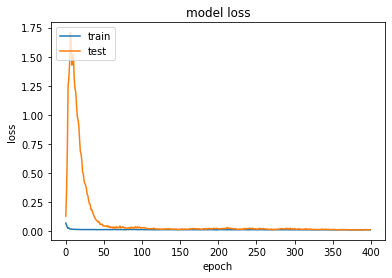

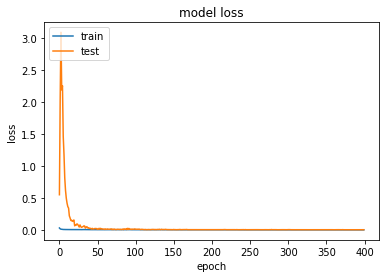

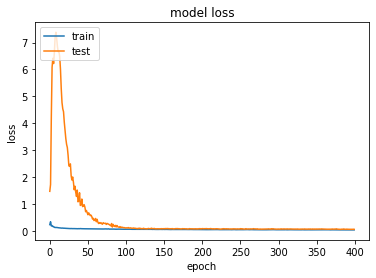

In [25]:

plot_loss(history_benzene)
plot_loss(history_carbon)
plot_loss(history_nitrogen)

In [26]:
ypred_benzene = model_benzene.predict(X_test)
ypred_carbon = model_carbon.predict(X_test)
ypred_nitrogen = model_nitrogen.predict(X_test)

In [27]:
pred_benzene = list(np.concatenate(ypred_benzene.tolist()).flat)
y_test_benzene = list(ytst_benzene)

pred_carbon = list(np.concatenate(ypred_carbon.tolist()).flat)
y_test_carbon = list(ytst_carbon)

pred_nitrogen = list(np.concatenate(ypred_nitrogen.tolist()).flat)
y_test_nitrogen = list(ytst_nitrogen)


Testing MAPE


In [28]:
mape_b = mape(y_test_benzene, pred_benzene).numpy()
mape_c = mape(y_test_carbon, pred_carbon).numpy()
mape_n = mape(y_test_nitrogen, pred_nitrogen).numpy()
(mape_b+mape_c+mape_n)/3

13.545892715454102

Testing MAE

In [29]:
mae_b = mae(y_test_benzene, pred_benzene).numpy()
mae_c = mae(y_test_carbon, pred_carbon).numpy()
mae_n = mae(y_test_nitrogen, pred_nitrogen).numpy()
(mae_b+mae_c+mae_n)/3

11.146890665094057

Testing RMSLE

In [30]:
rmsleb = np.sqrt(msle(y_test_benzene,pred_benzene))
rmslec = np.sqrt(msle(y_test_carbon, pred_carbon))
rmslen = np.sqrt(msle(y_test_nitrogen, pred_nitrogen)) 
(rmsleb + rmslec + rmslen)/3

0.14063248831155653

Testing RMSE

In [31]:
mse_b = np.sqrt(mse(y_test_benzene, pred_benzene).numpy())
mse_c = np.sqrt(mse(y_test_carbon, pred_carbon).numpy())
mse_n = np.sqrt(mse(y_test_nitrogen, pred_nitrogen).numpy())
(mse_b+mse_c+mse_n)/3

21.31191899410211

Testing $R^2$

In [32]:
metric = tfa.metrics.r_square.RSquare()
metric.update_state(y_test_nitrogen, pred_nitrogen)
r2_b = metric.result()
metric.update_state(y_test_nitrogen, pred_nitrogen)
r2_c = metric.result()
metric.update_state(y_test_nitrogen, pred_nitrogen)
r2_n = metric.result()
((r2_b + r2_c + r2_n)/3).numpy()

0.901272